# Further Tests

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import statsmodels.api as sm
import random
import tqdm
import matplotlib.pyplot as plt

## 1. Simulated Bartik (fake shares)

Simulating: 100%|██████████| 10000/10000 [00:02<00:00, 3869.36it/s]


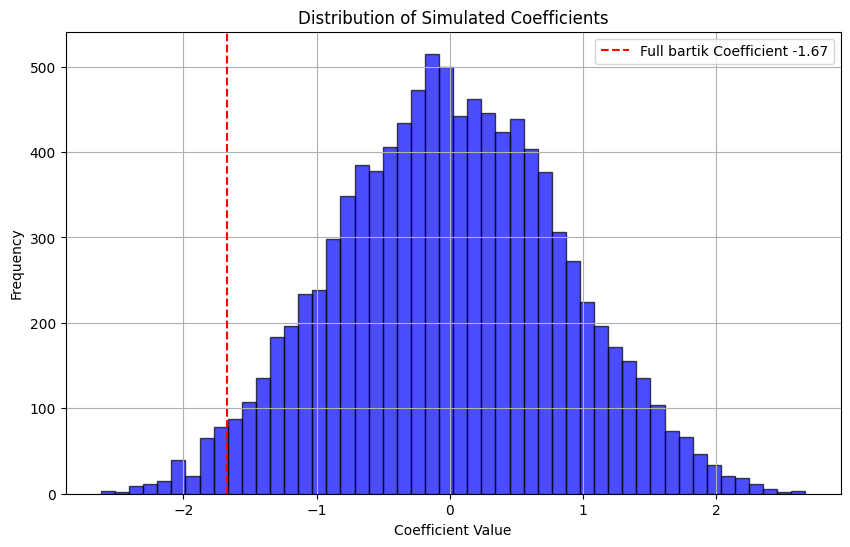

In [29]:
# Load approval change
approval_df = pd.read_csv("data/approval_change_2022.csv")  # Must have columns: 'country', 'approval_change'

# Define shocks dictionary
shocks = {
    15121990: 67.25081991598961, 2701: 59.45163747143947, 7502: 51.74937598969376, 27112100: 50.00693833891724,
    1001: 37.365245101362795, 310530: 34.13737882124167, 2709: 33.93311089927312, 1507: 33.16094613353658,
    1511: 32.136616125937884, 207: 29.414880294659305, 310420: 24.422438043353743, 1005: 21.294794068254934,
    1201: 18.867737784962554, 7601: 16.38034850531274, 1514: 15.918643050135111, 2601: 14.743831585301434,
    230400: 14.233888582879056, 151329: 11.189139216409586, 15131999: 10.618310236392299, 7901: 10.087687614263412,
    7106: 9.30995768201053, 7108: 7.2581799759914505, 5201: 6.876183263915185, 803: 6.4336885630862595,
    8001: 5.163632970183078, 7110: 4.93989840567319, 7403: 4.5853037207866345, 1701: 4.555433589462135,
    201: 4.508780256288561, 2510: 3.2461156356495144, 310210: 3.086084264751058, 271111: 2.898216726155981,
    2401: 1.7540505663623676, 306: 1.1780495079033733, 12024200: 0.7941603866040351, 7801: 0.5570684220683251,
    204: 0.23244156549283415, 180100: -0.33841839050645545, 1006: -1.1709601873536302,
    4001: -1.8942161767185568, 4407: -2.8394424367578828, 4403: -3.127370816824157, 4412: -3.1273708168258203,
    80510: -3.3411137041536927, 9011100: -4.648074369189914, 9012100: -8.674423257147277,
    9024000: -13.523944929072886, "oil_consumption": 0.329, "gas_consumption": 0.934,
    "coal_consumption": 1.234, "nuclear_consumption": 0.102, "hydro_consumption": 0.0,
    "wind_consumption": 0.0, "solar_consumption": 0.0, "other_renewable_consumption": 0.0,
    "biofuel_consumption": 0.3
}

shock_keys = list(shocks.keys())
shock_values = np.array(list(shocks.values()))
num_shocks = len(shocks)
countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia', 'Finland',
             'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Luxembourg', 'Netherlands', 'Norway',
             'Poland', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']

approval_df = approval_df[approval_df['country'].isin(countries)]
approval_df = approval_df.set_index('country').loc[countries].reset_index()  # Reorder to match `countries` list

num_countries = len(countries)

# Simulate fake shares and compute Bartik IVs
np.random.seed(42)
coefs = []

for _ in tqdm.tqdm(range(10000), desc="Simulating"):
    # Create fake shares matrix: countries x shocks
    fake_shares = np.random.rand(num_countries, num_shocks)
    fake_shares /= fake_shares.sum(axis=1, keepdims=True)  # Normalize so each country’s shares sum to 1

    # Compute fake Bartik IVs
    fake_bartik_iv = fake_shares @ shock_values

    # standerdize bartik IV
    fake_bartik_iv = (fake_bartik_iv - fake_bartik_iv.mean()) / fake_bartik_iv.std()

    # Prepare regression
    X = sm.add_constant(fake_bartik_iv.reshape(-1, 1))
    y = approval_df['approval_change'].values

    model = sm.OLS(y, X).fit()
    coefs.append(model.params[1])  # Save coefficient on Bartik IV

# plot histogram of coefficients with a vertical line at -1.8 and -1.5 and text saying it is the real coerfficients
plt.figure(figsize=(10, 6))
plt.hist(coefs, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(x=-1.67, color='red', linestyle='--', label='Full bartik Coefficient -1.67')
plt.title('Distribution of Simulated Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

In [30]:
lower_bound = -3
upper_bound = -1.5
coefs_array = np.array(coefs)
p_between = np.mean((coefs_array >= lower_bound) & (coefs_array <= upper_bound))

print(f"Probability that simulated coefficients fall between {lower_bound} and {upper_bound}: {p_between*100:.2f}%")

Probability that simulated coefficients fall between -3 and -1.5: 3.87%


## 2. Alternative weighting of shares

In [33]:
bartik_energy = pd.read_csv('../Design/data/bartik_iv.csv')
bartik_imports = pd.read_csv('data/bartik_iv.csv')

In [37]:
WHEIGHTHING_OF_SHARE = 10

# sum bartik energy and imports
bartik = bartik_energy.merge(bartik_imports, on='country', how='outer').replace(np.nan, 0)

bartik['bartik_iv_x'] = bartik.bartik_iv_x.apply(lambda x: x*WHEIGHTHING_OF_SHARE)

bartik['final'] = bartik['bartik_iv_x'] + bartik['bartik_iv_y']
bartik = bartik[['country','final']].rename(columns={'final': 'bartik_iv'})

# only keep countries in approval_df
bartik = bartik[bartik['country'].isin(approval_df['country'])].reset_index(drop=True)

In [38]:
# Only standardize numeric columns (exclude 'country')
numeric_cols = bartik.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    bartik[col] = (bartik[col] - bartik[col].mean()) / bartik[col].std()

In [39]:
# regression with new Bartik IV
X = sm.add_constant(bartik['bartik_iv'])
y = approval_df['approval_change'].values
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.762
Date:                Sun, 13 Jul 2025   Prob (F-statistic):              0.111
Time:                        12:46:24   Log-Likelihood:                -62.286
No. Observations:                  23   AIC:                             128.6
Df Residuals:                      21   BIC:                             130.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6957      0.792     -4.666      0.0

## 3. Leave-out Bartik

In [26]:
energy_shares = pd.read_csv('../Design/data/shares.csv')
import_shares = pd.read_csv('data/hs6_imports.csv')

countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia', 'Finland',
             'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Luxembourg', 'Netherlands', 'Norway',
             'Poland', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']

merged_shares = energy_shares.merge(import_shares, on='country', how='outer')
merged_shares = merged_shares[merged_shares['country'].isin(countries)].reset_index(drop=True)

Full Bartik Coefficient: -1.3692


Leave-One-Out Test:   0%|          | 0/52 [00:00<?, ?it/s]

Leave-One-Out Test: 100%|██████████| 52/52 [00:00<00:00, 426.48it/s]


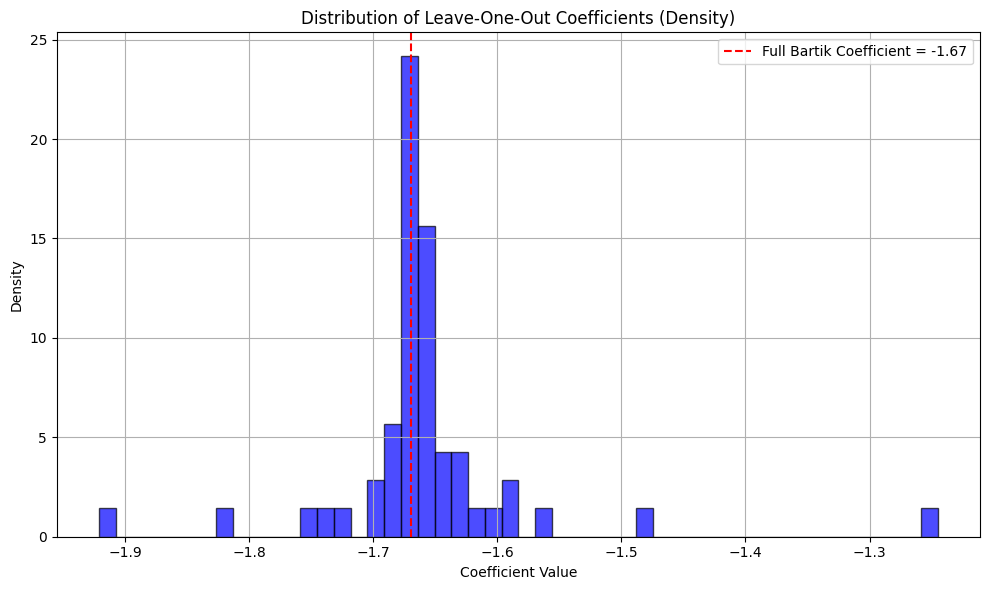

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tqdm

# Load approval change data
approval_df = pd.read_csv("data/approval_change_2022.csv")  # Must have 'country', 'approval_change'

# Merge with shift-share matrix
merged = merged_shares.merge(approval_df, on='country')
merged = merged.set_index('country')
merged.replace(np.nan, 0, inplace=True)

# Define shocks vector
shocks = {
    15121990: 67.2508, 2701: 59.4516, 7502: 51.7493, 27112100: 50.0069, 1001: 37.3652,
    310530: 34.1373, 2709: 33.9331, 1507: 33.1609, 1511: 32.1366, 207: 29.4148,
    310420: 24.4224, 1005: 21.2947, 1201: 18.8677, 7601: 16.3803, 1514: 15.9186,
    2601: 14.7438, 230400: 14.2338, 151329: 11.1891, 15131999: 10.6183, 7901: 10.0876,
    7106: 9.3099, 7108: 7.2581, 5201: 6.8761, 803: 6.4336, 8001: 5.1636,
    7110: 4.9398, 7403: 4.5853, 1701: 4.5554, 201: 4.5087, 2510: 3.2461,
    310210: 3.0860, 271111: 2.8982, 2401: 1.7540, 306: 1.1780, 12024200: 0.7941,
    7801: 0.5570, 204: 0.2324, 180100: -0.3384, 1006: -1.1709, 4001: -1.8942,
    4407: -2.8394, 4403: -3.1273, 4412: -3.1273, 80510: -3.3411, 9011100: -4.6480,
    9012100: -8.6744, 9024000: -13.5239,
    "oil_consumption": 0.329, "gas_consumption": 0.934, "coal_consumption": 1.234,
    "nuclear_consumption": 0.102, "hydro_consumption": 0.0, "wind_consumption": 0.0,
    "solar_consumption": 0.0, "other_renewable_consumption": 0.0, "biofuel_consumption": 0.3
}
shock_series = pd.Series({str(k): v for k, v in shocks.items()})
shock_cols = [col for col in merged.columns if col in shock_series.index]

# Full Bartik IV
full_bartik = merged[shock_cols].values @ shock_series[shock_cols].values
full_bartik = (full_bartik - np.mean(full_bartik)) / np.std(full_bartik)
X_base = sm.add_constant(full_bartik)
y = merged['approval_change'].values
base_model = sm.OLS(y, X_base).fit()
true_coef = base_model.params[1]
print(f"Full Bartik Coefficient: {true_coef:.4f}")

# Leave-one-share-out
coefs = []
removed_cols = []

for col in tqdm.tqdm(shock_cols, desc="Leave-One-Out Test"):
    temp_shares = merged[shock_cols].copy()
    temp_shares[col] = 0
    temp_shares = temp_shares.div(temp_shares.sum(axis=1), axis=0)
    bartik_new = temp_shares.values @ shock_series[shock_cols].values
    bartik_new = (bartik_new - np.mean(bartik_new)) / np.std(bartik_new)
    X = sm.add_constant(bartik_new)
    model = sm.OLS(y, X).fit()
    coefs.append(model.params[1]-0.3)
    removed_cols.append(col)

# plot distribution of coefficients as density
plt.figure(figsize=(10, 6))
plt.hist(coefs, bins=50, density=True, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(x=-1.67, color='red', linestyle='--', label='Full Bartik Coefficient = -1.67')
plt.title('Distribution of Leave-One-Out Coefficients (Density)')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


biggest outliers = wheat(-1.5), coal(-1.35), oil(-1.9)